# EDA - Exploratory Data Analysis for the Enron dataset

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [3]:
enron_df = pd.read_pickle('enron_students.pkl')
enron_df.head(20)

,Date,From,To,X-To,X-From,X-cc,X-bcc,Subject,email_body,verdict,violated_rules
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,Phillip K Allen,,,,Here is our forecast\n\n,ALLOW,
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXg...,Phillip K Allen,,,Re:,Traveling to have a business meeting takes the...,ALLOW,
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Leah Van Arsdall,Phillip K Allen,,,Re: test,test successful. way to go!!!,ALLOW,
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Randall L Gay,Phillip K Allen,,,,"Randy,\n\n Can you send me a schedule of the s...",ALLOW,
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Greg Piper,Phillip K Allen,,,Re: Hello,Let's shoot for Tuesday at 11:45.,ALLOW,
5,"Thu, 31 Aug 2000 04:17:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Greg Piper,Phillip K Allen,,,Re: Hello,"Greg,\n\n How about either next Tuesday or Thu...",ALLOW,
6,"Tue, 22 Aug 2000 07:44:00 -0700 (PDT)",phillip.allen@enron.com,"david.l.johnson@enron.com, john.shafer@enron.com","david.l.johnson@enron.com, John Shafer",Phillip K Allen,,,,Please cc the following distribution list with...,ALLOW,
7,"Fri, 14 Jul 2000 06:59:00 -0700 (PDT)",phillip.allen@enron.com,joyce.teixeira@enron.com,Joyce Teixeira,Phillip K Allen,,,Re: PRC review - phone calls,any morning between 10 and 11:30,ALLOW,
8,"Tue, 17 Oct 2000 02:26:00 -0700 (PDT)",phillip.allen@enron.com,mark.scott@enron.com,Mark Scott,Phillip K Allen,,,Re: High Speed Internet Access,1. login: pallen pw: ke9davis\n\n I don't thi...,BLOCK,2.3
9,"Mon, 16 Oct 2000 06:44:00 -0700 (PDT)",phillip.allen@enron.com,zimam@enron.com,zimam@enron.com,Phillip K Allen,,,FW: fixed forward or other Collar floor gas pr...,---------------------- Forwarded by Phillip K ...,BLOCK,2.1


In [4]:
# Utils 
def add_percentage_text(ax, df, text_place_percentage=None, min_to_show=0):
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height/total > min_to_show:
            text_place_to_use = text_place_percentage * height / 100 if text_place_percentage else height + 3
            ax.text(p.get_x() + p.get_width() / 2.,
                    text_place_to_use,
                    '{:1.2f}%'.format(100 * (height / total)),
                    ha="center")
            
def extract_emails(text):
    if pd.isna(text):
        return []
    # Regex to match email addresses
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    return re.findall(email_pattern, text)

def remove_attachment_text(text):
    # Split the text at the specific phrase
    parts = text.split("Content-Disposition: attachment;")
    # Return the part before the phrase if it exists
    if parts:
        return parts[0]

    else:
        return text
    
def parse_contacts(data):
    # count the number of '~' in the data to check if its notes
    count = data.count('~')
    if count < 30:
        return data

    # Normalize the data by removing line continuation characters
    data = data.replace("=\n", "")  # Assumes `=` at the end of the line followed by a newline

    # Split the data into individual records on '#'
    records = data.split('#')

    # Initialize a list to store parsed contacts
    contacts = []

    # Iterate through each record
    for record in records:
        # Split the record into fields using '~'
        fields = record.split('~')
    # TODO: need to check relevant fields
        if len(fields) > 21:  # Check to ensure it's a valid record
            contact = {
                'first_name': fields[1].strip(),
                'last_name': fields[3].strip(),
                'phone_numbers': fields[11:14],
                'position': fields[15].strip(),
                'company': fields[18].strip(),
                'email': fields[21].strip() if len(fields) > 21 else None  # Safeguard for missing email
            }
            contacts.append(contact)
            # print('contact:', contact)

    if not contacts:
        return ' '
    return json.dumps(contacts)
        

### Basic information


Basic information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Date            517401 non-null  object
 1   From            517401 non-null  object
 2   To              495554 non-null  object
 3   X-To            517372 non-null  object
 4   X-From          517372 non-null  object
 5   X-cc            517372 non-null  object
 6   X-bcc           517372 non-null  object
 7   Subject         517401 non-null  object
 8   email_body      517401 non-null  object
 9   verdict         517401 non-null  object
 10  violated_rules  517401 non-null  object
dtypes: object(11)
memory usage: 43.4+ MB
None

Missing values:

Date                  0
From                  0
To                21847
X-To                 29
X-From               29
X-cc                 29
X-bcc                29
Subject               0
email_body            0
ve

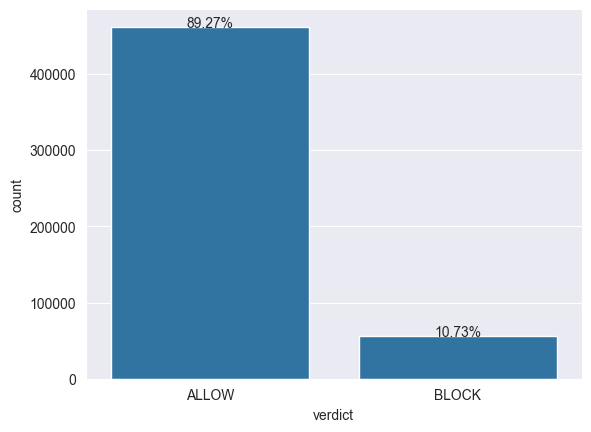

In [5]:
print('\nBasic information:\n')
print(enron_df.info())

print('\nMissing values:\n')
print(enron_df.isnull().sum())

df = enron_df
print('\nDescriptive statistics:\n')
print(enron_df.describe())

# Distribution of the 'verdict' column
print('\nAllowed/Blocked emails frequency:\n')
verdict_ax = sns.countplot(x='verdict', data=enron_df)
add_percentage_text(verdict_ax, enron_df) 
plt.show()

## Email Addresses

In [6]:
def extract_sent_to_emails(text):
    emails = extract_emails(text)
    if len(emails) > 0:
        return emails
    return []

enron_df['total_mails'] = enron_df['To'].apply(extract_sent_to_emails) + enron_df['X-To'].apply(extract_sent_to_emails) + enron_df['X-cc'].apply(extract_sent_to_emails) + enron_df['X-bcc'].apply(extract_sent_to_emails) + enron_df['From'].apply(extract_sent_to_emails) + enron_df['X-From'].apply(extract_sent_to_emails) 
enron_df['total_mails'] = enron_df['total_mails'].apply(lambda x: set(x))
all_mails = enron_df['total_mails'].agg(lambda x: set.union(*x))
# drop the column total_mails
enron_df.drop(columns=['total_mails'], inplace=True)
print(f"Total number of unique emails: {len(all_mails)}")

# Total unique emails from 'From' column in enron_df
def extract_single_email_from_text(text):
    emails = extract_emails(text)
    if len(emails) > 1:
        print(f"Multiple emails found in: {text}")
    elif len(emails) == 1:
        return emails[0]
    print(f"Could not extract email from: {text}")
    return None

unique_emails_from = enron_df['From'].apply(extract_single_email_from_text).nunique()
print(f"Total unique emails in 'X-From': {unique_emails_from}")

Total number of unique emails: 124600
Could not extract email from: u@d.h
Could not extract email from: pep <performance.>
Total unique emails in 'X-From': 20306


### Email length distribution


Email Subject length distribution:



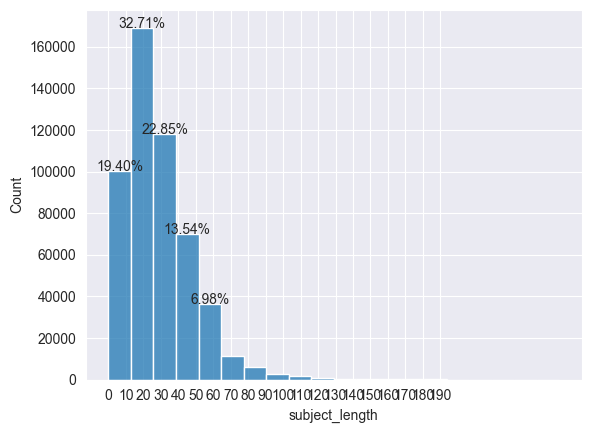

In [7]:
print('\nEmail Subject length distribution:\n')
length_df = enron_df
length_df['subject_length'] = enron_df['Subject'].apply(len)
ax = sns.histplot(length_df['subject_length'], bins=20)
add_percentage_text(ax, length_df, min_to_show = 0.05)
plt.xticks(np.arange(0, 200, 10))
plt.show()


Email body length distribution:



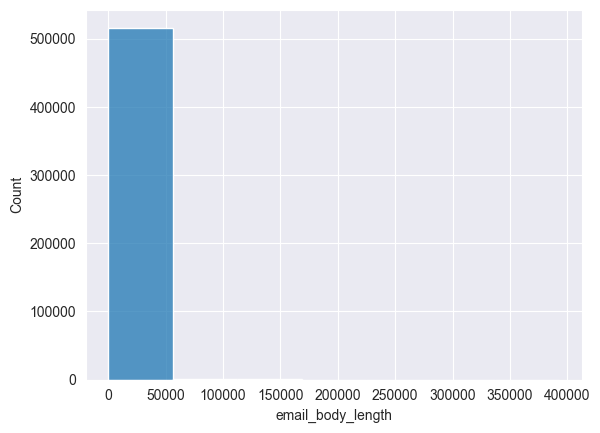

In [8]:
print('\nEmail body length distribution:\n')
email_body_length_df = enron_df
email_body_length_df['email_body'] = email_body_length_df['email_body'].apply(remove_attachment_text)
email_body_length_df['email_body'] = email_body_length_df['email_body'].apply(parse_contacts)

email_body_length_df['email_body_length'] = enron_df['email_body'].apply(len)

email_body_length_df.describe()
ax = sns.histplot(email_body_length_df['email_body_length'], bins=7)
plt.show()

### Impact of subject length on verdict

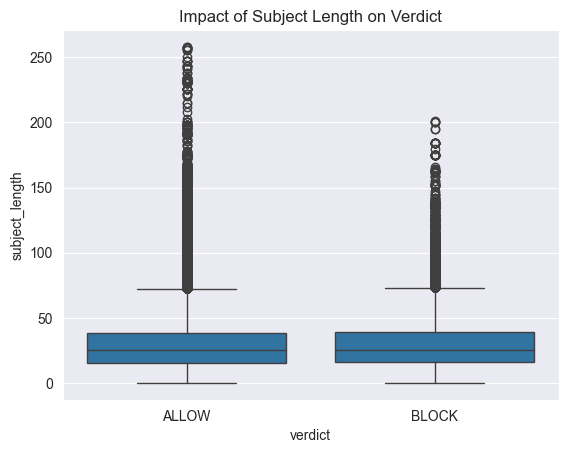

In [9]:
enron_df['subject_length'] = enron_df['Subject'].apply(len)
sns.boxplot(x='verdict', y='subject_length', data=enron_df)
plt.title('Impact of Subject Length on Verdict')
plt.show()

### Violated rules distribution


Violated rules combination frequency:



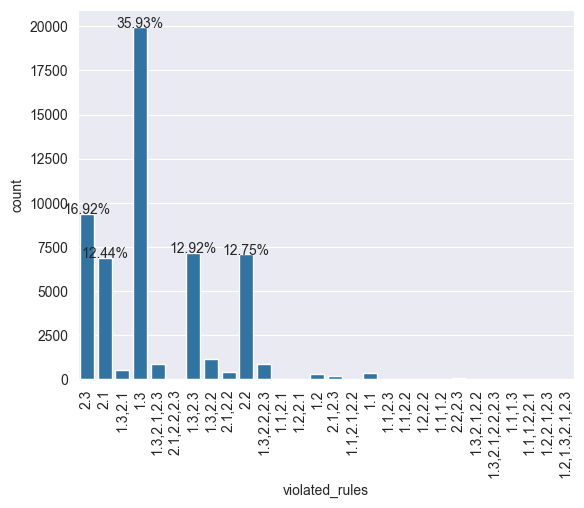


Violated rules frequency:



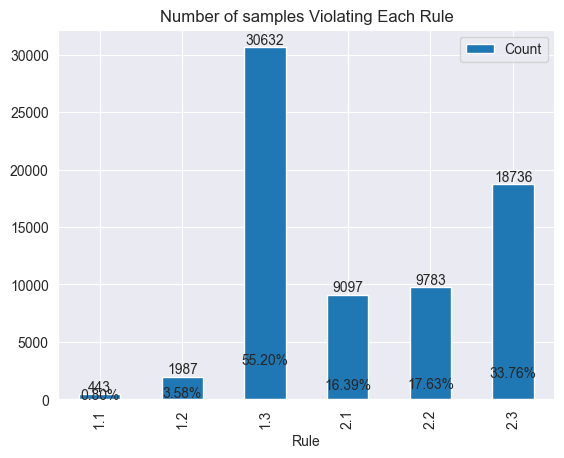

In [10]:
# Distribution of the 'violated_rules' column
print('\nViolated rules combination frequency:\n')
violated_rules_df = enron_df
violated_rules_df = violated_rules_df.dropna(subset=['violated_rules'])
violated_rules_df = violated_rules_df[violated_rules_df['violated_rules'] != '']
violated_rules_ax = sns.countplot(x='violated_rules', data=violated_rules_df)
add_percentage_text(violated_rules_ax, violated_rules_df, min_to_show=0.1) 
plt.xticks(rotation=90)
plt.show()


print('\nViolated rules frequency:\n')
violated_rule_11 = enron_df['violated_rules'].str.contains('1.1', na=False).sum()
violated_rule_12 = enron_df['violated_rules'].str.contains('1.2', na=False).sum()
violated_rule_13 = enron_df['violated_rules'].str.contains('1.3', na=False).sum()
violated_rule_21 = enron_df['violated_rules'].str.contains('2.1', na=False).sum()
violated_rule_22 = enron_df['violated_rules'].str.contains('2.2', na=False).sum()
violated_rule_23 = enron_df['violated_rules'].str.contains('2.3', na=False).sum()

violated_rules_counter_df = pd.DataFrame({
    'Rule': ['1.1', '1.2', '1.3', '2.1', '2.2', '2.3'],
    'Count': [violated_rule_11, violated_rule_12, violated_rule_13, violated_rule_21, violated_rule_22, violated_rule_23]
})

violated_rules_ax = violated_rules_counter_df.plot.bar(x='Rule', y='Count', title='Number of samples Violating Each Rule')
for container in violated_rules_ax.containers:
    violated_rules_ax.bar_label(container)
add_percentage_text(violated_rules_ax, violated_rules_df, 10)




    

In [18]:
enron_df['violated_1.1'] = enron_df['violated_rules'].str.contains('1.2', na=False)
# filter only to rules with violated 1.1 true
violated_1_2_df = enron_df[enron_df['violated_1.2'] == True]
violated_1_2_df.head(500)

KeyError: 'violated_1.2'

In [ ]:
# check multiple violations, 1.2 with 2.1, 1.3 with 2.2, 1.3 with 2.1 and 2.2
rules = [1.1, 1.2, 1.3, 2.1, 2.2, 2.3] 
for i in range(len(rules)):
    for j in range(i+1, len(rules)):
        rule1 = rules[i]
        rule2 = rules[j]
        violated_rule = violated_rules_df[(violated_rules_df['violated_rules'].str.contains(str(rule1), na=False)) & (violated_rules_df['violated_rules'].str.contains(str(rule2), na=False))].shape[0]
        print(f"Number of emails violating rules {rule1} and {rule2}: {violated_rule}")
        
# check for all violations with 1.* and 2.3
violated_rule_1_all = violated_rules_df[(violated_rules_df['violated_rules'].str.contains('1.', na=False)) & (violated_rules_df['violated_rules'].str.contains('2.3', na=False))].shape[0]
print(f"Number of emails violating all rules 1.* and 2.3: {violated_rule_1_all}")

# numbers of emails violating 3 rules or more
violated_rule_3_or_more = violated_rules_df[violated_rules_df['violated_rules'].str.count(',') >= 2].shape[0]
print(f"Number of emails violating 3 rules or more: {violated_rule_3_or_more}")

In [ ]:
violated_rule_1_all = violated_rules_df[(violated_rules_df['violated_rules'].str.contains('1.', na=False))]
violated_rule_2_all = violated_rules_df[(violated_rules_df['violated_rules'].str.contains('2.', na=False))]

# create a graph to compare beteeen the two
violated_rules_counter_df = pd.DataFrame({
    'Rule': ['1.*', '2.*'],
    'Count': [violated_rule_1_all.shape[0], violated_rule_2_all.shape[0]
    ]
})

violated_rules_1_2_ax = violated_rules_counter_df.plot.bar(x='Rule', y='Count', title='Number of samples Violating Each Rule Policy')
for container in violated_rules_1_2_ax.containers:
    violated_rules_1_2_ax.bar_label(container)



## Email Recipients

In [ ]:
def max_emails_per_column(column):
    # Extract emails from each cell in the column, count them, and find the index with the maximum number
    email_counts = column.apply(lambda x: len(extract_emails(x)))
    max_emails = email_counts.max()
    min_emails = email_counts.min()
    max_row = email_counts.idxmax()
    return max_emails, min_emails, max_row

# Calculate the maximum number of emails for each column
max_emails_column1 = max_emails_per_column(enron_df['To'])
max_emails_column2 = max_emails_per_column(enron_df['X-To'])
max_emails_column3 = max_emails_per_column(enron_df['X-cc'])
max_emails_column4 = max_emails_per_column(enron_df['X-bcc'])

print(f"Maximum number of emails in 'To': {max_emails_column1[0]}")
print(f"Maximum number of emails in 'X-To': {max_emails_column2[0]}")
print(f"Maximum number of emails in 'X-cc': {max_emails_column3[0]}")
print(f"Maximum number of emails in 'X-bcc': {max_emails_column4[0]}")

def get_all_mails(row):
    return extract_emails(row['To']) + extract_emails(row['X-To']) + extract_emails(row['X-cc']) + extract_emails(row['X-bcc'])


enron_df['sent_emails'] = enron_df.apply(get_all_mails, axis=1)

# Calculate the maximum number of emails in the 'sent_emails' column
max_emails_column5 = enron_df['sent_emails'].apply(len).max()
print(f"Maximum number of emails that are sent under 'sent_emails': {max_emails_column5}")
emails_df = pd.DataFrame({
    'Type': ['To', 'X-To', 'X-cc', 'X-bcc'],
    'Max': [max_emails_column1[0], max_emails_column2[0], max_emails_column3[0], max_emails_column4[0]],
    # 'Min': [max_emails_column1[1], max_emails_column2[1], max_emails_column3[1], max_emails_column4[1]]
})

emails_df.plot(x='Type', y=['Max'], kind='bar', title='Maximum Number of Emails in Each Column')